In [1]:
import sys
sys.path.append('../../')

# import os
import torch
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [6]:
gpu_id = 2
num_cores = 4
torch.cuda.set_device(gpu_id)

In [7]:
bs = 8  # batch size
size = 256  # image size
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/hr/')

In [58]:
class EMDataSet(Dataset):

    def __init__(self, data_pth):
        self.img_list = list(data_pth.glob('*.tif'))
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.img_list[idx]
        image = torch.FloatTensor(io.imread(img_name)[:,:,0])
        h, w = image.shape
        half_h, half_w = int(h/2), int(w/2)
        pieces = torch.stack([image[i*half_h:(i+1)*half_h, j*half_w:(j+1)*half_w] 
                          for i in range(2) for j in range(2)])
        indices = torch.randperm(4)
        shuffled = torch.zeros([h, w])
        for piece, coor in zip(pieces[indices], [(0,0), (0,1), (1,0), (1,1)]):
            shuffled[coor[0]*half_h:(coor[0]+1)*half_h, 
                     coor[1]*half_w:(coor[1]+1)*half_w] = piece
        sample = {'shuffled': shuffled, 'original': image}
        return sample

In [59]:
jigsaw_dataset = EMDataSet(data_pth)

In [60]:
dataloader = DataLoader(jigsaw_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

0 torch.Size([4, 600, 900])
1 torch.Size([4, 600, 900])
2 torch.Size([4, 600, 900])
3 torch.Size([4, 600, 900])


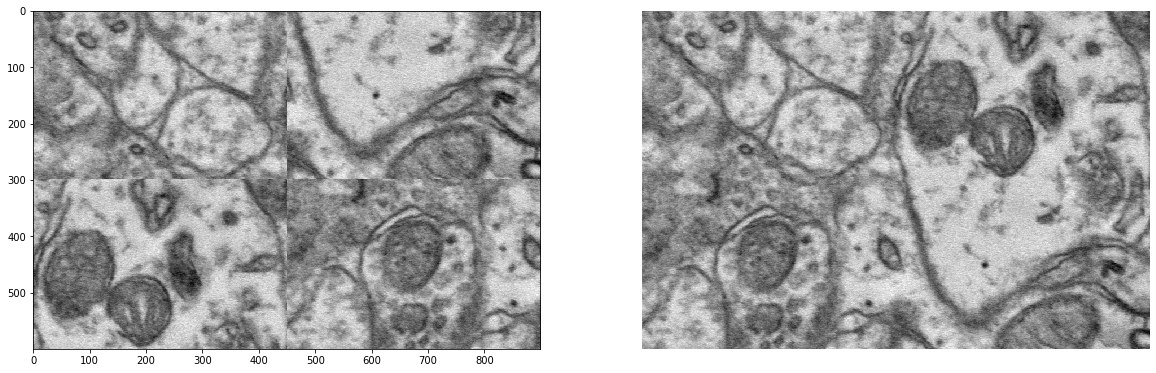

In [64]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['shuffled'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure(figsize=(20,20))
        plt.subplot(1,2,1)
        plt.imshow(sample_batched['shuffled'][3], cmap='gray')
        plt.subplot(1,2,2)
        plt.imshow(sample_batched['original'][3], cmap='gray')
        plt.axis('off')
        plt.ioff()
        plt.show()
        break